# Adversarial Autoencoder on MNIST Dataset

<img src="adversarial_autoencoder_model.png">

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


## Utilities

In [14]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(x_test, batch_size=batch_size)
    
    cmap = plt.get_cmap('RdBu', np.max(y_test)-np.min(y_test)+1)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap=cmap, vmin = np.min(y_test)-.5, vmax = np.max(y_test)+.5)
    plt.colorbar(ticks=np.arange(np.min(y_test),np.max(y_test)+1))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

## Load dataset

In [3]:
# load the dataset without labels

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape images
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

11493376/11490434 [==============================] - 5s 0us/step


## Build the adversarial autoencoder model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
code (Dense)                 (None, 2)                 1026      
Total params: 402,946
Trainable params: 402,946
Non-trainable params: 0
_________________________________________________________________


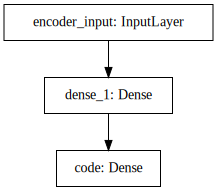

In [4]:
# AAE model = encoder + decoder + discriminator + generator

# TODO: implement: 1) GAUSSIAN POSTERIOR; 2) UNIVERSAL APPROXIMATOR POSTERIOR

# DETERMINISTIC POSTERIOR Q(z|x)
# build encoder model 
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(latent_dim, name='code')(x)

# instantiate encoder model
encoder = Model(inputs, x, name='encoder')
encoder.summary()
plot_model(encoder, to_file='img/aae_mlp_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (InputLayer)            (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


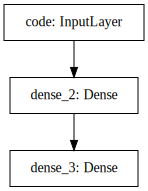

In [5]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='code')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='img/aae_mlp_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discr_input (InputLayer)     (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


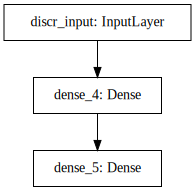

In [6]:
# build discriminator model

discr_inputs = Input(shape=(2,), name='discr_input')
x = Dense(32, activation='relu')(discr_inputs)
check = Dense(1, activation='sigmoid')(x)

# instantiate decoder model
discriminator = Model(discr_inputs, check, name='discriminator')
discriminator.summary()
plot_model(decoder, to_file='img/aae_mlp_discriminator.png', show_shapes=True)
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 402946    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 806,674
Trainable params: 806,674
Non-trainable params: 0
_________________________________________________________________


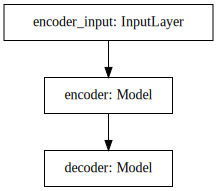

In [7]:
# instantiate AAE model
outputs = decoder(encoder(inputs))
aae = Model(inputs, outputs, name='aae_mlp')
aae.summary()
plot_model(aae, to_file='img/aae_mlp_autoencoder.png', show_shapes=True)
SVG(model_to_dot(aae).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 402946    
_________________________________________________________________
discriminator (Model)        (None, 1)                 129       
Total params: 403,075
Trainable params: 403,075
Non-trainable params: 0
_________________________________________________________________


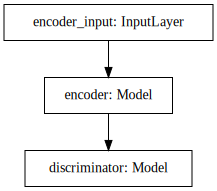

In [8]:
# generator model
generator_inputs = inputs
generator = Model(generator_inputs, discriminator(encoder(inputs)))
generator.summary()
plot_model(generator, to_file='img/aae_mlp_generator.png', show_shapes=True)
SVG(model_to_dot(generator).create(prog='dot', format='svg'))

## Train the adversarial autoencoder

Let's visualize the results of a model during training using the TensorFlow backend and the TensorBoard callback.

!tensorboard --logdir==training:/tmp/aae --host=127.0.0.1

open [tensorboard](127.0.0.1:6006)

In [9]:
# let's train the models

discriminator.trainable = False
discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
generator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
aae.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")
    
for epoch in range(epochs):
    np.random.shuffle(x_train)
    
    for i in range(int(len(x_train) / batch_size)):
        aae.trainable = True
        encoder.trainable = True
        decoder.trainable = True
        
        # Reconstruction phase
        batch = x_train[i*batch_size:i*batch_size+batch_size]
        #aae.train_on_batch(batch, batch)
        aae_history = aae.fit(x=batch, 
                              y=batch, 
                              epochs=1, 
                              batch_size=batch_size, 
                              validation_split=0.0, 
                              verbose=0)#,
                              #callbacks=[TensorBoard(log_dir='/tmp/aae_1')])
        
        # Regularization phase
        #discriminator.trainable = True
        fake_pred = encoder.predict(batch)
        real_pred = np.random.standard_normal((batch_size,latent_dim)) # prior distribution
        discriminator_batch_x = np.concatenate([fake_pred, real_pred])
        discriminator_batch_y = np.concatenate([np.zeros(batch_size), np.ones(batch_size)])
        #discriminator.train_on_batch(discriminator_batch_x, discriminator_batch_y)
        discriminator_history = discriminator.fit(x=discriminator_batch_x, 
                                                  y=discriminator_batch_y, 
                                                  epochs=1, 
                                                  batch_size=batch_size, 
                                                  validation_split=0.0, 
                                                  verbose=0)#,
                                                  #callbacks=[TensorBoard(log_dir='/tmp/aae_2')])
        
        #generator.trainable = True
        #encoder.trainable = True
        #discriminator.trainable = False
        #generator.train_on_batch(batch, np.ones(batch_size))
        generator_history = generator.fit(x=batch, 
                                          y=np.ones(batch_size), 
                                          epochs=1, 
                                          batch_size=batch_size, 
                                          validation_split=0.0, verbose=0)#,
                                          #callbacks=[TensorBoard(log_dir='/tmp/aae_3')])
    
    print("Epoch {}".format(epoch + 1))
    print("reconstruction loss: {0:.4f}, generator loss: {1:.4f}".format(
          *[aae_history.history["loss"][0], generator_history.history["loss"][0]]))
    
    
    aae.save('models/aae_mlp_mnist.h5')
    encoder.save('models/aae_mlp_encoder_mnist.h5')
    decoder.save('models/aae_mlp_decoder_mnist.h5')
    generator.save('models/aae_mlp_generator_mnist.h5')  
    discriminator.save('models/aee_mlp_discriminator_mnist.h5') 

Instructions for updating:
Use tf.cast instead.
Epoch 1
reconstruction loss: 0.0492, generator loss: 0.0160
Epoch 2
reconstruction loss: 0.0492, generator loss: 0.0370
Epoch 3
reconstruction loss: 0.0464, generator loss: 0.0703
Epoch 4
reconstruction loss: 0.0443, generator loss: 0.0658
Epoch 5
reconstruction loss: 0.0446, generator loss: 0.0585
Epoch 6
reconstruction loss: 0.0447, generator loss: 0.0406
Epoch 7
reconstruction loss: 0.0463, generator loss: 0.0338
Epoch 8
reconstruction loss: 0.0404, generator loss: 0.0508
Epoch 9
reconstruction loss: 0.0402, generator loss: 0.0670
Epoch 10
reconstruction loss: 0.0407, generator loss: 0.0442
Epoch 11
reconstruction loss: 0.0404, generator loss: 0.0466
Epoch 12
reconstruction loss: 0.0390, generator loss: 0.0388
Epoch 13
reconstruction loss: 0.0419, generator loss: 0.0466
Epoch 14
reconstruction loss: 0.0438, generator loss: 0.0444
Epoch 15
reconstruction loss: 0.0399, generator loss: 0.0334
Epoch 16
reconstruction loss: 0.0403, generato

## Visualization

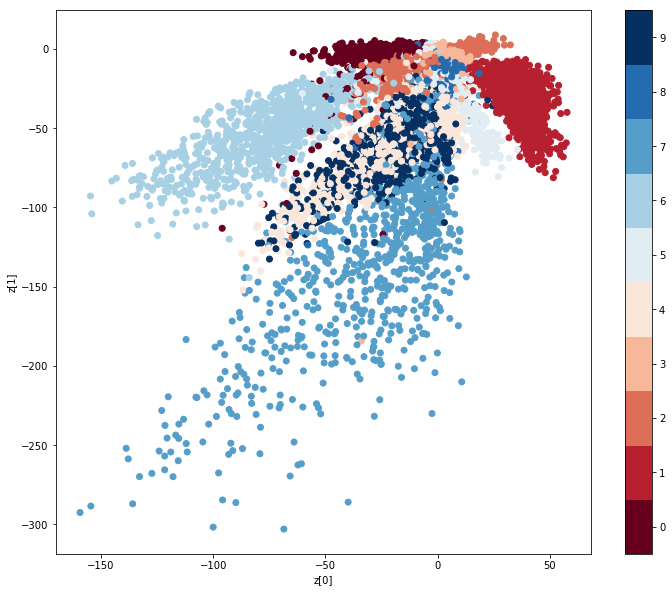

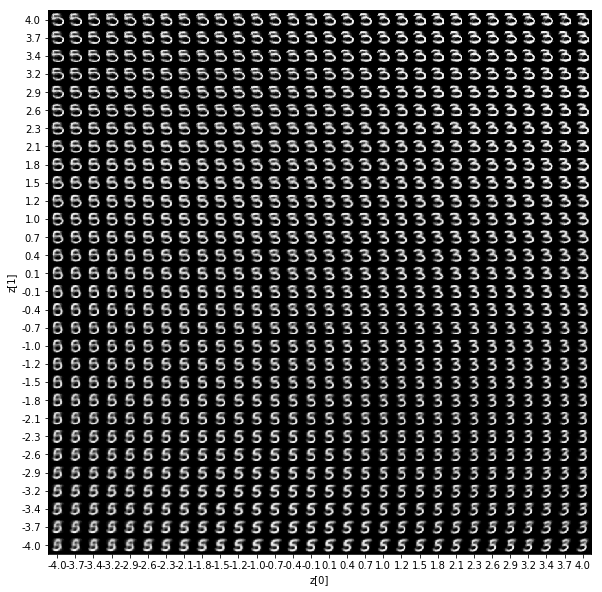

In [15]:
models = (encoder, decoder)
data = (x_test, y_test)

# Generate distribution on latent space and manifold of the autoencoder
plot_results(models, data, batch_size=batch_size, model_name="aae_mlp")

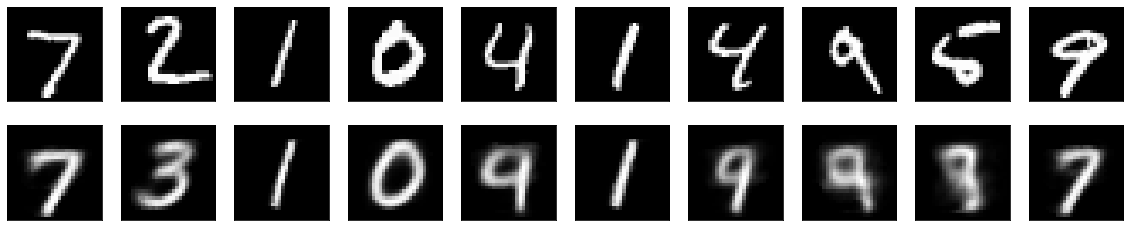

In [16]:
decoded_imgs = aae.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()